In [251]:
from graphMatching import *
from networkx import read_edgelist
from scipy.io import loadmat
from model import *
from utils import *

In [252]:
# import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

In [253]:
data = "MS" # args.dataset

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
train_features = {}
if (data == "ACM_DBLP"):
	train_set = ["ACM", "DBLP"]
	input_dim = 17
	b = np.load('data/ACM-DBLP.npz')
	train_features["ACM"] = [torch.from_numpy(b["x1"]).float()]
	train_features["DBLP"] = [torch.from_numpy(b["x2"]).float()]
	test_pairs = b['test_pairs'].astype(np.int32)
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = 1024
	output_feature_size = 1024
	lr = 0.0001
	epoch = 100
elif (data == "Douban Online_Offline"):
	a1, f1, a2, f2, test_pairs = load_douban()
	f1 = f1.A
	f2 = f2.A
	train_set = ["Online", "Offline"]
	input_dim = 538
	test_pairs = torch.tensor(np.array(test_pairs, dtype=int)) - 1
	test_pairs = test_pairs.numpy()
	train_features["Online"] = [torch.from_numpy(f1).float()]
	train_features["Offline"] = [torch.from_numpy(f2).float()]
	NUM_HIDDEN_LAYERS = 6
	HIDDEN_DIM = 512
	output_feature_size = 512
	lr = 0.0001
	epoch = 100
elif (data == "MS"):
	train_set = ["pck1_1", "pck1_2"] # change
	input_dim = 3 # features
	
	df_nodes_1 = pd.read_csv("graphs_data/nodes_{}.csv".format(train_set[0]))
	df_nodes_2 = pd.read_csv("graphs_data/nodes_{}.csv".format(train_set[1]))
	
	train_features[train_set[0]] = [torch.from_numpy(df_nodes_1.iloc[:, 2:].values).float()]
	train_features[train_set[1]] = [torch.from_numpy(df_nodes_2.iloc[:, 2:].values).float()]
	
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = 1024
	output_feature_size = 1024
	lr = 0.0001
	epoch = 100

In [254]:
""" temp = torch.from_numpy(b["x1"]).float() # G1, features
print(temp.shape)
temp """

' temp = torch.from_numpy(b["x1"]).float() # G1, features\nprint(temp.shape)\ntemp '

In [255]:
""" temp = torch.from_numpy(b["x2"]).float() # G2, features
print(temp.shape)
temp """

' temp = torch.from_numpy(b["x2"]).float() # G2, features\nprint(temp.shape)\ntemp '

In [256]:
""" temp = b["test_pairs"]
print(temp.shape)
temp """

' temp = b["test_pairs"]\nprint(temp.shape)\ntemp '

In [257]:
# test_pairs

In [258]:
train_set

['pck1_1', 'pck1_2']

In [259]:
# for Mentos
encoder = "GIN"
use_input_augmentation = True
use_output_augmentation = False
print("Loading training datasets")
train_loader = {}
for dataset in train_set:
	df_edges_orange = pd.read_csv("graphs_data/edges_{}.csv".format(dataset))
	edges = df_edges_orange.iloc[:, [0, 1]].values
	
	n = train_features[dataset][0].shape[0]
	matrix = torch.zeros(n, n)

	for item in edges:
		matrix[item[0]][item[1]] = 1
		matrix[item[1]][item[0]] = 1

	train_loader[dataset] = [matrix]

train_loader

Loading training datasets


{'pck1_1': [tensor([[0., 1., 1.,  ..., 0., 0., 0.],
          [1., 0., 1.,  ..., 1., 1., 1.],
          [1., 1., 0.,  ..., 1., 1., 1.],
          ...,
          [0., 1., 1.,  ..., 0., 1., 1.],
          [0., 1., 1.,  ..., 1., 0., 1.],
          [0., 1., 1.,  ..., 1., 1., 0.]])],
 'pck1_2': [tensor([[0., 1., 1.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 1., 1., 1.],
          [1., 0., 0.,  ..., 1., 0., 0.],
          ...,
          [0., 1., 1.,  ..., 0., 1., 1.],
          [0., 1., 0.,  ..., 1., 0., 1.],
          [0., 1., 0.,  ..., 1., 1., 0.]])]}

In [260]:
train_loader.keys()

dict_keys(['pck1_1', 'pck1_2'])

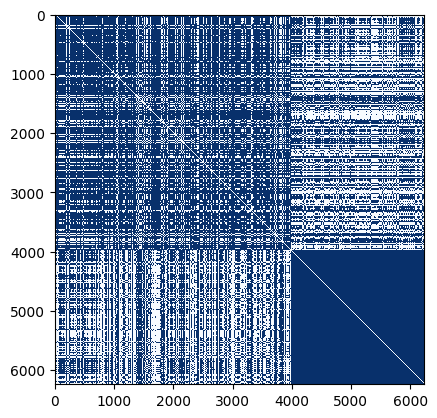

In [261]:
plt.imshow(train_loader[train_set[0]][0].cpu().numpy(), cmap="Blues", interpolation="none")
plt.show()

In [262]:
""" temp = train_loader["ACM"][0]
print(temp.shape)
temp """

' temp = train_loader["ACM"][0]\nprint(temp.shape)\ntemp '

In [263]:
""" temp = train_loader["DBLP"][0]
print(temp.shape)
temp """

' temp = train_loader["DBLP"][0]\nprint(temp.shape)\ntemp '

In [264]:
model = GAE(NUM_HIDDEN_LAYERS,
			input_dim,
			HIDDEN_DIM,
			output_feature_size, activation=F.relu,
			use_input_augmentation=use_input_augmentation,
			use_output_augmentation=use_output_augmentation,
			encoder=encoder).to(device)
model

GAE(
  (base_gcn): GIN(
    (in_proj): Linear(in_features=3, out_features=1024, bias=True)
    (convs): ModuleList(
      (0-13): 14 x GINConv(
        (linear): Linear(in_features=1027, out_features=1024, bias=True)
      )
    )
    (out_proj): Linear(in_features=15360, out_features=1024, bias=True)
  )
)

In [265]:
print("Generating training features")


Generating training features


In [266]:
train_loader

{'pck1_1': [tensor([[0., 1., 1.,  ..., 0., 0., 0.],
          [1., 0., 1.,  ..., 1., 1., 1.],
          [1., 1., 0.,  ..., 1., 1., 1.],
          ...,
          [0., 1., 1.,  ..., 0., 1., 1.],
          [0., 1., 1.,  ..., 1., 0., 1.],
          [0., 1., 1.,  ..., 1., 1., 0.]])],
 'pck1_2': [tensor([[0., 1., 1.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 1., 1., 1.],
          [1., 0., 0.,  ..., 1., 0., 0.],
          ...,
          [0., 1., 1.,  ..., 0., 1., 1.],
          [0., 1., 0.,  ..., 1., 0., 1.],
          [0., 1., 0.,  ..., 1., 1., 0.]])]}

In [267]:
print("Fitting model")
# fit_GAE_real(data, len(train_set) * (1 + 1), model, epoch, train_loader, train_features, device, lr,test_pairs)
# fit_GAE_real(data, no_samples, GAE, epoch, train_loader, train_features, device, lr, test_pairs):

no_samples = len(train_set) * (1 + 1)
GAE = model
# ---

best_hitAtOne = 0
best_hitAtFive = 0
best_hitAtTen = 0
best_hitAtFifty = 0
optimizer = Adam(GAE.parameters(), lr=lr, weight_decay=5e-4)

for step in tqdm(range(epoch)):
	loss = 0
	
	for dataset in train_loader.keys():
		S = train_loader[dataset][0]
		initial_features = train_features[dataset]
		
		for i in range(len(train_loader[dataset])):
			adj_tensor = train_loader[dataset][i]
			adj = coo_matrix(adj_tensor.numpy())
			adj_norm = preprocess_graph(adj)
			pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
			norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

			adj_label = coo_matrix(S.numpy())
			adj_label = sparse_to_tuple(adj_label)

			adj_norm = torch.sparse.FloatTensor(torch.LongTensor(adj_norm[0].T),
												torch.FloatTensor(adj_norm[1]),
												torch.Size(adj_norm[2])).to(device)
			adj_label = torch.sparse.FloatTensor(torch.LongTensor(adj_label[0].T),
												torch.FloatTensor(adj_label[1]),
												torch.Size(adj_label[2])).to(device)

			initial_feature = initial_features[i].to(device)

			weight_mask = adj_label.to_dense().view(-1) == 1
			weight_tensor = torch.ones(weight_mask.size(0))
			weight_tensor[weight_mask] = pos_weight
			weight_tensor = weight_tensor.to(device)
			z = GAE(initial_feature, adj_norm)
			A_pred = torch.sigmoid(torch.matmul(z,z.t()))
			loss += norm * F.binary_cross_entropy(A_pred.view(-1), adj_label.to_dense().view(-1),
														weight=weight_tensor)
	
	optimizer.zero_grad()
	loss = loss / no_samples
	loss.backward()
	optimizer.step()

	# ---
	keys = list(train_loader.keys())
	S1 = train_loader[keys[0]][0]
	S2 = train_loader[keys[1]][0]
	
	adj_S1 = coo_matrix(S1.numpy())
	adj_norm_1 = preprocess_graph(adj_S1)
	adj_norm_1 = torch.sparse.FloatTensor(torch.LongTensor(adj_norm_1[0].T),
											torch.FloatTensor(adj_norm_1[1]),
											torch.Size(adj_norm_1[2])).to(device)
	adj_S2 = coo_matrix(S2.numpy())
	adj_norm_2 = preprocess_graph(adj_S2)
	adj_norm_2 = torch.sparse.FloatTensor(torch.LongTensor(adj_norm_2[0].T),
											torch.FloatTensor(adj_norm_2[1]),
											torch.Size(adj_norm_2[2])).to(device)
	""" if (data == "ACM_DBLP"):
		S1_feat = train_features["ACM"][0]
		S2_feat = train_features["DBLP"][0]
	elif (data == "Douban Online_Offline"):
		S1_feat = train_features["Online"][0]
		S2_feat = train_features["Offline"][0] """

	S1_feat = train_features[train_set[0]][0]
	S2_feat = train_features[train_set[1]][0]

	# ---
	S1_emb = GAE(S1_feat.to(device), adj_norm_1).detach()
	S2_emb = GAE(S2_feat.to(device), adj_norm_2).detach()

	D = torch.cdist(S1_emb, S2_emb, 2) # Euclidean distance

Fitting model


100%|██████████| 100/100 [38:02<00:00, 22.82s/it]


In [268]:
print(D.shape)
D

torch.Size([6242, 6239])


tensor([[12.8858, 13.1990, 11.2741,  ..., 14.8778, 13.7783, 18.6992],
        [12.6786, 12.3643, 14.3546,  ..., 10.6749, 11.7790,  6.8461],
        [ 3.2178,  2.8858,  4.8840,  ...,  1.3221,  2.3962,  2.8088],
        ...,
        [ 7.3822,  7.0783,  9.0575,  ...,  5.3705,  6.4730,  1.5551],
        [ 7.4115,  7.1078,  9.0858,  ...,  5.3984,  6.5009,  1.5750],
        [ 9.3853,  9.0733, 11.0615,  ...,  7.3765,  8.4817,  3.5539]],
       device='cuda:0')

#### Truth

In [269]:
""" print(data)
print(test_pairs.shape)
print(test_pairs) """

' print(data)\nprint(test_pairs.shape)\nprint(test_pairs) '

In [270]:
""" if (data == "ACM_DBLP"):
	test_pairs_ = test_pairs
elif (data == "Douban Online_Offline"):
	test_pairs_ = test_pairs.T
	
truth = test_pairs_[test_pairs_[:, 1].argsort()]
print(truth.shape)
truth """

' if (data == "ACM_DBLP"):\n\ttest_pairs_ = test_pairs\nelif (data == "Douban Online_Offline"):\n\ttest_pairs_ = test_pairs.T\n\t\ntruth = test_pairs_[test_pairs_[:, 1].argsort()]\nprint(truth.shape)\ntruth '

In [271]:
""" truth_ = test_pairs_[test_pairs_[:, 0].argsort()]
print(truth_.shape)
truth_ """

' truth_ = test_pairs_[test_pairs_[:, 0].argsort()]\nprint(truth_.shape)\ntruth_ '

#### Metadata

In [272]:
df_nodes_1 = pd.read_csv("graphs_data/nodes_{}.csv".format(train_set[0]))
df_nodes_1
map1 = dict(zip(df_nodes_1.iloc[:, 0].values, df_nodes_1.iloc[:, 1].values))
map1

df_nodes_2 = pd.read_csv("graphs_data/nodes_{}.csv".format(train_set[1]))
df_nodes_2
map2 = dict(zip(df_nodes_2.iloc[:, 0].values, df_nodes_2.iloc[:, 1].values))
# map2

#### Option 0

In [ ]:
def hungarian(D):
	print("0")
	P = torch.zeros_like(D)
	matrix = D.tolist()
	m = Munkres()
	print("1")
	indexes = m.compute(matrix)
	print("2")
	total = 0
	for r, c in tqdm(indexes):
		print(r)
		P[r][c] = 1
		total += matrix[r][c]
	return P.t()

X = hungarian(D)
print(X.shape)
# online_offline: 215m
# acm_dblp: 2112m
X

In [ ]:
# save

X = X.cpu().numpy()
np.save("P_hungarian_ACM_DBLP", X)

In [ ]:
# load

X = np.load("P_hungarian.npy")
X

In [ ]:
option0 = []
m, n = X.shape
for i in range(m):
	for j in range(n):
		if X[i][j] == 1:
			option0.append([j, i]) # S, S_hat
option0 = np.array(option0)
print(len(option0))
option0

In [ ]:
matching = test_matching(truth, option0)
print(len(matching))
print(len(matching) / len(truth))
matching

#### Option 1

In [273]:
total_cost, assignments = hungarian_algorithm(D.cpu())

In [274]:
option1 = np.array(assignments)
option1 = option1[option1[:, 1].argsort()]
print(option1.shape)
option1

(6239, 2)


array([[2560,    0],
       [2439,    1],
       [5736,    2],
       ...,
       [2545, 6236],
       [1760, 6237],
       [2301, 6238]])

In [275]:
option1_ = option1[:, [1, 0]]
option1_

array([[   0, 2560],
       [   1, 2439],
       [   2, 5736],
       ...,
       [6236, 2545],
       [6237, 1760],
       [6238, 2301]])

In [276]:
""" matching = test_match(truth, option1)
print(len(matching))
print(len(matching) / len(truth))
matching """

' matching = test_match(truth, option1)\nprint(len(matching))\nprint(len(matching) / len(truth))\nmatching '

In [277]:
# Analysis

def match_nodes(option, map1, map2):
    df_match = pd.DataFrame(option)
    df_match.columns = ["g1", "g2"]
    df_match

    df_match.replace({"g1": map1}, inplace=True) 
    df_match.replace({"g2": map2}, inplace=True) 
    df_match

    df_match = df_match[df_match["g1"] == df_match["g2"]]
    return sorted(df_match.iloc[:, 0].values)

df_match = match_nodes(option1.copy(), map1, map2)
df_match

[174, 374, 1312, 1603, 3771, 3797, 4770, 5054, 5164, 5324, 5641, 5736, 6168]

In [278]:
""" G1 = build_graph(adj_norm_1)
G2 = build_graph(adj_norm_2)

plot_match(G1, G2, matching)"""

' G1 = build_graph(adj_norm_1)\nG2 = build_graph(adj_norm_2)\n\nplot_match(G1, G2, matching)'

#### Option 2

In [279]:
import pygmtools as pygm

X = pygm.hungarian(D.cpu().numpy())
print(X.shape)
X

(6242, 6239)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [280]:
option2 = matrix_to_edge(X)
option2

(6239, 2)


array([[5729,    0],
       [3251,    1],
       [2825,    2],
       ...,
       [5700, 6236],
       [4828, 6237],
       [5191, 6238]])

In [281]:
option2_ = option2[:, [1, 0]]
option2_

array([[   0, 5729],
       [   1, 3251],
       [   2, 2825],
       ...,
       [6236, 5700],
       [6237, 4828],
       [6238, 5191]])

In [282]:
""" matching = test_match(truth, option2)
print(len(matching))
print(len(matching) / len(truth))
matching """

' matching = test_match(truth, option2)\nprint(len(matching))\nprint(len(matching) / len(truth))\nmatching '

In [283]:
df_match = match_nodes(option2.copy(), map1, map2)
df_match

[636]

In [284]:
""" G1 = build_graph(adj_norm_1)
G2 = build_graph(adj_norm_2)
plot_match(G1, G2, matching) """

' G1 = build_graph(adj_norm_1)\nG2 = build_graph(adj_norm_2)\nplot_match(G1, G2, matching) '

#### Option 3

In [285]:
indices = []
for i in range(D.shape[0]):
	dist_list = D[i]
	sorted_neighbors = torch.argsort(dist_list).cpu()
	indices.append([i, sorted_neighbors[0]])

option3 = np.array(indices)
option3 = option3[option3[:, 1].argsort()]
print(option3.shape)
option3

(6242, 2)


array([[  38,    0],
       [2560,    0],
       [5736,    2],
       ...,
       [ 708, 6235],
       [ 905, 6236],
       [2301, 6238]])

In [286]:
option3_ = option3[:, [1, 0]]
option3_

array([[   0,   38],
       [   0, 2560],
       [   2, 5736],
       ...,
       [6235,  708],
       [6236,  905],
       [6238, 2301]])

In [287]:
""" matching = test_match(truth, option3)
print(len(matching))
print(len(matching) / len(truth))
matching """

' matching = test_match(truth, option3)\nprint(len(matching))\nprint(len(matching) / len(truth))\nmatching '

In [288]:
df_match = match_nodes(option3, map1, map2)
df_match

[84, 119, 124, 475, 878, 1255, 3626, 3771, 4264, 4389, 4715, 6096, 6193]

In [289]:
""" G1 = build_graph(adj_norm_1)
G2 = build_graph(adj_norm_2)
plot_match(G1, G2, matching) """

' G1 = build_graph(adj_norm_1)\nG2 = build_graph(adj_norm_2)\nplot_match(G1, G2, matching) '

#### Option 4

In [290]:
X = greedy_match(D)
X = X.todense()
X = np.array(X)
print(X.shape)
print(X)

(6242, 6239)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [291]:
option4 = matrix_to_edge(X)
option4

(6239, 2)


array([[1150,    0],
       [3113,    1],
       [1144,    2],
       ...,
       [3125, 6236],
       [3122, 6237],
       [3119, 6238]])

In [292]:
option4_ = option4[:, [1, 0]]
option4_

array([[   0, 1150],
       [   1, 3113],
       [   2, 1144],
       ...,
       [6236, 3125],
       [6237, 3122],
       [6238, 3119]])

In [293]:
""" matching = test_match(truth, option4)
print(len(matching))
print(len(matching) / len(truth))
matching """

' matching = test_match(truth, option4)\nprint(len(matching))\nprint(len(matching) / len(truth))\nmatching '

In [294]:
df_match = match_nodes(option4, map1, map2)
df_match

[4539]

In [295]:
""" G1 = build_graph(adj_norm_1)
G2 = build_graph(adj_norm_2)
plot_match(G1, G2, matching) """

' G1 = build_graph(adj_norm_1)\nG2 = build_graph(adj_norm_2)\nplot_match(G1, G2, matching) '

#### Option 5

In [296]:
D_ = complete_to_square(D.cpu(), pad_value=100.0)
print(D_.shape)
D_

(6242, 6242)


array([[ 12.88584232,  13.1989727 ,  11.27408409, ..., 100.        ,
        100.        , 100.        ],
       [ 12.67858791,  12.36432266,  14.35463905, ..., 100.        ,
        100.        , 100.        ],
       [  3.2177639 ,   2.8857646 ,   4.88400602, ..., 100.        ,
        100.        , 100.        ],
       ...,
       [  7.38224602,   7.07834911,   9.05754185, ..., 100.        ,
        100.        , 100.        ],
       [  7.41152239,   7.10777807,   9.08582687, ..., 100.        ,
        100.        , 100.        ],
       [  9.38528061,   9.07334995,  11.06152916, ..., 100.        ,
        100.        , 100.        ]])

In [297]:
X = get_match(torch.tensor(D_), device)
print(X.shape)
X

torch.Size([6242, 6242])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [298]:
option5 = matrix_to_edge(X)
option5

(6242, 2)


array([[5788,    0],
       [5948,    1],
       [5249,    2],
       ...,
       [4548, 6239],
       [1885, 6240],
       [3144, 6241]])

In [299]:
option5_ = option5[:, [1, 0]]
option5_

array([[   0, 5788],
       [   1, 5948],
       [   2, 5249],
       ...,
       [6239, 4548],
       [6240, 1885],
       [6241, 3144]])

In [300]:
""" matching = test_match(truth, option5_) # ACM_DBLP (option5_)
print(len(matching))
print(len(matching) / len(truth))
matching """

' matching = test_match(truth, option5_) # ACM_DBLP (option5_)\nprint(len(matching))\nprint(len(matching) / len(truth))\nmatching '

In [301]:
df_match = match_nodes(option5, map1, map2)
df_match

[4145]

In [302]:
""" G1 = build_graph(adj_norm_1)
G2 = build_graph(adj_norm_2)
plot_match(G1, G2, matching) """

' G1 = build_graph(adj_norm_1)\nG2 = build_graph(adj_norm_2)\nplot_match(G1, G2, matching) '

---

In [303]:
a = torch.tensor([[0.0,  0.0], [0.0, 1.0], [0.0,  2.0]])
print(a)
b = torch.tensor([[0.0, 1.0 ], [1.0,  1.0]])
print(b)
torch.cdist(a, b, p=2)

tensor([[0., 0.],
        [0., 1.],
        [0., 2.]])
tensor([[0., 1.],
        [1., 1.]])


tensor([[1.0000, 1.4142],
        [0.0000, 1.0000],
        [1.0000, 1.4142]])

In [304]:
a = torch.tensor([[4.01, 3.0, 2.0, 0.1, 4.0]])
print(a)
torch.argsort(a, dim=1)

tensor([[4.0100, 3.0000, 2.0000, 0.1000, 4.0000]])


tensor([[3, 2, 1, 4, 0]])

In [305]:
a = np.array([[9, 2, 3],
			  [4, 5, 6],
			  [7, 0, 5]])

a[a[:, 2].argsort()]

array([[9, 2, 3],
       [7, 0, 5],
       [4, 5, 6]])

In [306]:
a = torch.randn(4, 4)
print(a)

torch.argmin(a)


tensor([[ 0.4548, -1.0062,  0.5188,  0.3027],
        [-0.6604,  0.4135, -1.6810,  1.2078],
        [ 0.0692,  0.1376,  1.1396,  0.5799],
        [ 1.7649,  0.6876, -0.4978,  1.2050]])


tensor(6)